before starting:
BraTS (Brain Tumor Segmentation) is an annual challenge focused on evaluating the performance of algorithms for the segmentation of brain tumors, specifically gliomas, in multimodal MRI scans. Here's a breakdown of what you provided:

### Key Focus Areas of BraTS 2020:
1. **Segmentation of Gliomas (Task 1)**: The main goal of the BraTS 2020 challenge is to segment brain tumors, specifically gliomas, in MRI scans. Gliomas are a type of brain tumor that can vary in appearance, shape, and histology. The task is to segment three different regions of the tumor:
   - **Enhancing Tumor (ET)**: The part of the tumor that actively takes up contrast agents and appears brighter in post-contrast scans (label 4).
   - **Peritumoral Edema (ED)**: Swelling around the tumor caused by the presence of the tumor (label 2).
   - **Necrotic and Non-Enhancing Tumor Core (NCR/NET)**: The dead tissue inside the tumor and parts that do not enhance with contrast (label 1).

2. **Prediction of Overall Survival (Task 2)**: This task involves predicting the overall survival of patients based on their MRI scans. The challenge uses clinical data about patients' survival to train and evaluate models that predict survival outcomes from MRI scans.

3. **Distinguishing Pseudoprogression from True Tumor Recurrence (Task 3)**: Pseudoprogression occurs when the tumor appears to grow on an MRI due to treatment effects, rather than true tumor recurrence. The challenge aims to train models to differentiate between these two situations.

4. **Uncertainty Estimation (Task 4)**: This task focuses on quantifying the uncertainty of tumor segmentation. Algorithms not only make predictions but also provide a measure of how confident they are in their predictions. This is crucial in clinical applications, where decision-making relies on understanding the certainty of results.

### Evaluation:
The evaluation of the different tasks is based on different reference standards:
- **Manual Segmentation Labels**: The ground truth for segmentation tasks is provided by human raters who manually segment the tumor regions.
- **Clinical Data**: For survival prediction and tumor recurrence, the clinical data provides reference for evaluation.
- **Clinical Evaluation**: Experts assess the clinical status of patients to evaluate models' performance in distinguishing between pseudoprogression and true recurrence.
- **Uncertainty Estimation**: The algorithms' ability to estimate their own uncertainty in segmenting tumor regions is evaluated.

### Imaging Data:
The MRI data used in BraTS comes from multiple institutions (19 in total), with different clinical protocols and scanners. The data includes multiple types of MRI scans:
- **T1-weighted (T1)**: Shows the anatomical structure of the brain.
- **Post-contrast T1-weighted (T1Gd)**: Shows how the tumor absorbs contrast agents, highlighting tumor areas.
- **T2-weighted (T2)**: Highlights water-containing tissues, such as edema.
- **T2 Fluid Attenuated Inversion Recovery (T2-FLAIR)**: Helps in highlighting areas with edema or tumor presence, as fluid appears dark.

The MRI scans are pre-processed in several ways to standardize them:
- **Co-registration**: Aligning all scans to a common anatomical template.
- **Resolution Standardization**: All images are resampled to the same voxel size (1 mm³).
- **Skull Stripping**: Removal of non-brain tissues (e.g., skull, scalp) to focus only on brain tissue.

### Segmentation:
Manual segmentation has been performed by one to four raters, and their results have been validated by experienced neuro-radiologists. These manual segmentations serve as the "ground truth" for evaluating the performance of automatic segmentation algorithms in the challenge.

In summary, BraTS 2020 challenges participants to develop algorithms that can accurately segment different parts of gliomas from multimodal MRI scans, predict survival, differentiate between pseudoprogression and tumor recurrence, and quantify the uncertainty in their predictions. The data is pre-processed to ensure consistency across different sources, making it easier for participants to focus on algorithm development.


In [ ]:
import os
import torch
import logging

import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
import matplotlib.animation as anim
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec


import nibabel as nib
import torch.nn as nn
import torch.optim as optim

import torch.nn.functional as F


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from tqdm import tqdm


from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import confusion_matrix

import cv2

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("awsaf49/brats20-dataset-training-validation")
data_dir = path + "/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
train_dir = path + "/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
val_dir = path +"/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData"

100%|██████████| 4.16G/4.16G [03:09<00:00, 23.6MB/s]

Extracting files...


## qui dentro ci sono le cose per farlo funzionare con nii

In [ ]:
class BrainTumorDataset(Dataset):

    def __init__(self, patient_list, data_dir, is_train=True, transform=None, slice_range=(60, 100)):
        self.data_dir = data_dir
        self.is_train = is_train
        self.transform = transform
        self.modalities = ["flair", "t1", "t1ce", "t2"]

        # Excluding Patient 355 (due to image problem)
        self.patients = [p for p in patient_list if not p.endswith(".csv") and "355" not in p]

        self.slice_range = slice_range  # Only load a range of slices to save memory

    def load_nifti(self, path):
        nifti_img = nib.load(path)
        return np.array(nifti_img.get_fdata(), dtype=np.float32)

    def __len__(self):
        return len(self.patients)

    def __getitem__(self, idx):
        patient_id = self.patients[idx]

        # Excluding Patient 355 (again)
        if patient_id == "BraTS20_Training_355":
            return None

        patient_path = os.path.join(self.data_dir, patient_id)

        # Load 4 MR modalities
        images = []
        #rememeber that modalities has ["flair", "t1", "t1ce", "t2"]
        for modality in self.modalities:
            img_path = os.path.join(patient_path, f"{patient_id}_{modality}.nii")
            img = self.load_nifti(img_path)

            # Only keep the central axial slices where tumor is most likely to be visible
            start_slice, end_slice = self.slice_range
            img = img[:, :, start_slice:end_slice]

            # Z-score normalization for better stability
            if np.std(img) > 0:
                img = (img - np.mean(img)) / np.std(img)
            else:
                img = np.zeros_like(img)

            images.append(img)

        # Stack images as channels
        images = np.stack(images, axis=0)  # (4, H, W, D_reduced)

        # If it is a train_set load segmentation mask too
        if self.is_train:
            # Try multiple possible segmentation file names
            seg_paths = [
                os.path.join(patient_path, f"{patient_id}_seg.nii"),
                os.path.join(patient_path, f"{patient_id}_Segm.nii"),
                os.path.join(patient_path, f"{patient_id}_Segmentation.nii")
            ]

            # Find the first existing segmentation file
            seg_path = next((path for path in seg_paths if os.path.exists(path)), None)

            if seg_path is None:
                print(f"Warning: No segmentation file found for patient {patient_id}.")
                mask = np.zeros_like(images[0], dtype=np.int64)  # Empty mask as numpy array
            else:
                mask = self.load_nifti(seg_path)

                # Get the same slice range
                mask = mask[:, :, self.slice_range[0]:self.slice_range[1]]

                # Convert labels
                mask[mask == 4] = 3  # Reassign label 4 to 3 (Enhancing Tumor)
        else:
            mask = None

        # Apply transformations on the numpy arrays before converting to tensors
        if self.transform is not None:
            if self.is_train:
                transformed = self.transform(image=images, mask=mask)
                images = transformed["image"]
                mask = transformed["mask"]
            else:
                transformed = self.transform(image=images)
                images = transformed["image"]

        # Convert to PyTorch tensors AFTER transformations
        if not isinstance(images, torch.Tensor):
            images = torch.tensor(images, dtype=torch.float32)

        if self.is_train and mask is not None:
            if not isinstance(mask, torch.Tensor):
                mask = torch.tensor(mask, dtype=torch.long)
            else:
                mask = mask.to(dtype=torch.long)

        return (images, mask) if self.is_train else images

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import numpy as np
class AlbumentationsSliceTransform:
    def __init__(self):
        self.transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5)
        ])

    def __call__(self, image, mask=None):
        # Check if image is a tensor and convert to numpy if needed
        if isinstance(image, torch.Tensor):
            image = image.detach().cpu().numpy()

        C, H, W, D = image.shape
        transformed_slices = []
        transformed_masks = []

        for d in range(D):
            slice_img = np.moveaxis(image[:, :, :, d], 0, -1)
            if mask is not None:
                slice_mask = mask[:, :, d]
                transformed = self.transform(image=slice_img, mask=slice_mask)
                transformed_slices.append(np.moveaxis(transformed["image"], -1, 0))
                transformed_masks.append(transformed["mask"])
            else:
                transformed = self.transform(image=slice_img)
                transformed_slices.append(np.moveaxis(transformed["image"], -1, 0))

        transformed_image = np.stack(transformed_slices, axis=-1)

        if mask is not None:
            transformed_mask = np.stack(transformed_masks, axis=-1)
            return {"image": transformed_image, "mask": transformed_mask}
        else:
            return {"image": transformed_image}


In [ ]:
  # Optimize memory by selecting a subset of patients for quick testing
def get_subset_patients(patient_list, ratio=0.3):
    """Get a subset of patients for memory-efficient training"""
    n_patients = max(2, int(len(patient_list) * ratio))
    return random.sample(patient_list, n_patients)

In [ ]:
def visualize_samples_with_colors(data_dir, BraTS20_Training_00n):
    flair = data_dir+ BraTS20_Training_00n + BraTS20_Training_00n +'_flair.nii'
    mask = data_dir+ BraTS20_Training_00n + BraTS20_Training_00n +'_seg.nii'
    t1 = data_dir+ BraTS20_Training_00n + BraTS20_Training_00n +'_t1.nii'
    t2 = data_dir+ BraTS20_Training_00n + BraTS20_Training_00n +'_t2.nii'
    t1ce = data_dir+ BraTS20_Training_00n + BraTS20_Training_00n +'_t1ce.nii'

    flair_img = nib.load(flair)
    flair_img = np.asanyarray(flair_img.dataobj)
    flair_img = np.rot90(flair_img)

    sample_mask = nib.load(mask)
    sample_mask = np.asanyarray(sample_mask.dataobj)
    sample_mask = np.rot90(sample_mask)

    t1_img = nib.load(t1)
    t1_img = np.asanyarray(t1_img.dataobj)
    t1_img  = np.rot90(t1_img)

    t2_img = nib.load(t2)
    t2_img = np.asanyarray(t2_img.dataobj)
    t2_img  = np.rot90(t2_img)

    t1ce_img = nib.load(t1ce)
    t1ce_img = np.asanyarray(t1ce_img.dataobj)
    t1ce_img  = np.rot90(t1ce_img)

    mask_WT = sample_mask.copy()
    mask_WT[mask_WT == 1] = 1
    mask_WT[mask_WT == 2] = 1
    mask_WT[mask_WT == 4] = 1

    mask_TC = sample_mask.copy()
    mask_TC[mask_TC == 1] = 1
    mask_TC[mask_TC == 2] = 0
    mask_TC[mask_TC == 4] = 1

    mask_ET = sample_mask.copy()
    mask_ET[mask_ET == 1] = 0
    mask_ET[mask_ET == 2] = 0
    mask_ET[mask_ET == 4] = 1

    fig = plt.figure(figsize=(20, 10))

    gs = gridspec.GridSpec(nrows=2, ncols=5, height_ratios=[1, 1.5])

    fontsize = 10
    #  Varying density along a streamline
    ax0 = fig.add_subplot(gs[0, 0])
    flair = ax0.imshow(flair_img[:,:,65], cmap='bone')
    ax0.set_title("FLAIR", fontsize = fontsize, weight='bold', y=-0.2)
    fig.colorbar(flair)

    #  Varying density along a streamline
    ax1 = fig.add_subplot(gs[0, 1])
    t1 = ax1.imshow(t1_img[:,:,65], cmap='bone')
    ax1.set_title("T1", fontsize = fontsize, weight='bold', y=-0.2)
    fig.colorbar(t1)

    #  Varying density along a streamline
    ax2 = fig.add_subplot(gs[0, 2])
    t2 = ax2.imshow(t2_img[:,:,65], cmap='bone')
    ax2.set_title("T2", fontsize = fontsize, weight='bold', y=-0.2)
    fig.colorbar(t2)

    #  Varying density along a streamline
    ax3 = fig.add_subplot(gs[0, 3])
    t1ce = ax3.imshow(t1ce_img[:,:,65], cmap='bone')
    ax3.set_title("T1 contrast", fontsize = fontsize, weight='bold', y=-0.2)
    fig.colorbar(t1ce)

        #  Varying density along a streamline
    ax4 = fig.add_subplot(gs[1, 1:3])

    #ax4.imshow(np.ma.masked_where(mask_WT[:,:,65]== False,  mask_WT[:,:,65]), cmap='summer', alpha=0.6)
    l1 = ax4.imshow(mask_WT[:,:,65], cmap='summer',)
    l2 = ax4.imshow(np.ma.masked_where(mask_TC[:,:,65]== False,  mask_TC[:,:,65]), cmap='rainbow', alpha=0.6)
    l3 = ax4.imshow(np.ma.masked_where(mask_ET[:,:,65] == False, mask_ET[:,:,65]), cmap='winter', alpha=0.6)

    ax4.set_title("", fontsize=fontsize, weight='bold', y=-0.1)

    _ = [ax.set_axis_off() for ax in [ax0,ax1,ax2,ax3, ax4]]

    colors = [im.cmap(im.norm(1)) for im in [l1,l2, l3]]
    labels = ['Non-Enhancing tumor core', 'Peritumoral Edema ', 'GD-enhancing tumor']
    patches = [ mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]
    # put those patched as legend-handles into the legend
    plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4,fontsize = 'xx-large',
              title='Mask Labels', title_fontsize=18, edgecolor="black",  facecolor='#c5c6c7')

    plt.suptitle("Multimodal Scans -  Data | Manually-segmented mask - Target", fontsize=20, weight='bold')

    fig.savefig("data_sample.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
    fig.savefig("data_sample.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')

In BraTS, le immagini MRI multimodali sono fondamentali per la segmentazione dei tumori cerebrali. Nel codice che hai riportato, vengono caricate quattro immagini distinte:  

1. **T1-contrast-enhanced (T1ce)**  
   - **File caricato**: `t1ce = load_nifti_file(t1ce_path)`  
   - **Descrizione**: È un'immagine T1 pesata con **mezzo di contrasto** (Gadolinium, Gd).  
   - **Utilità**:  
     - Evidenzia la regione del **tumore che assorbe il contrasto** (**Enhancing Tumor, ET - label 4**).  
     - Utile per identificare la crescita attiva del tumore.  
     - Migliora la visibilità della barriera emato-encefalica compromessa.  

2. **T2-weighted (T2)**  
   - **File caricato**: `t2 = load_nifti_file(t2_path)`  
   - **Descrizione**: Un'immagine pesata in **T2** senza contrasto.  
   - **Utilità**:  
     - Mette in evidenza le zone con **liquido**, quindi aiuta a identificare il **peritumoral edema (ED - label 2)**.  
     - Buona per distinguere i tumori dai tessuti sani circostanti.  

3. **FLAIR (T2-FLAIR: Fluid Attenuated Inversion Recovery)**  
   - **File caricato**: `flair = load_nifti_file(flair_path)`  
   - **Descrizione**: Variante della T2 in cui il **liquido cerebrospinale (CSF) viene attenuato**, rendendo più visibili altre strutture.  
   - **Utilità**:  
     - È particolarmente utile per individuare il **peritumoral edema (ED - label 2)**.  
     - Filtra il segnale proveniente dal liquido cerebrospinale, rendendo più chiare le anomalie.  

4. **Mask (Segmentazione Ground Truth, se in training)**  
   - **File caricato**: `mask = load_nifti_file(mask_path) if self.is_training else None`  
   - **Descrizione**: È la **segmentazione manuale** del tumore, disponibile solo in fase di training.  
   - **Utilità**:  
     - Serve come ground truth per allenare il modello.  
     - Contiene 4 classi di etichette (0, 1, 2, 4) per distinguere le diverse regioni del tumore.  
     - Usata per calcolare metriche di valutazione (es. **Dice Score**).  

### **Riassunto delle Modalità di Imaging in BraTS**
| Modalità MRI  | Descrizione | Identifica meglio |
|--------------|------------|------------------|
| **T1ce**    | T1 pesata con contrasto (Gd) | **Enhancing Tumor (ET - Label 4)** |
| **T2**      | T2 pesata senza contrasto | **Edema peritumorale (ED - Label 2)** |
| **FLAIR**   | T2-FLAIR (attenuazione del CSF) | **Edema peritumorale (ED - Label 2) con più chiarezza** |
| **Mask**    | Segmentazione manuale (solo training) | Ground truth per allenamento del modello |

Queste modalità, combinate insieme, permettono di ottenere una segmentazione accurata del tumore. 🚀

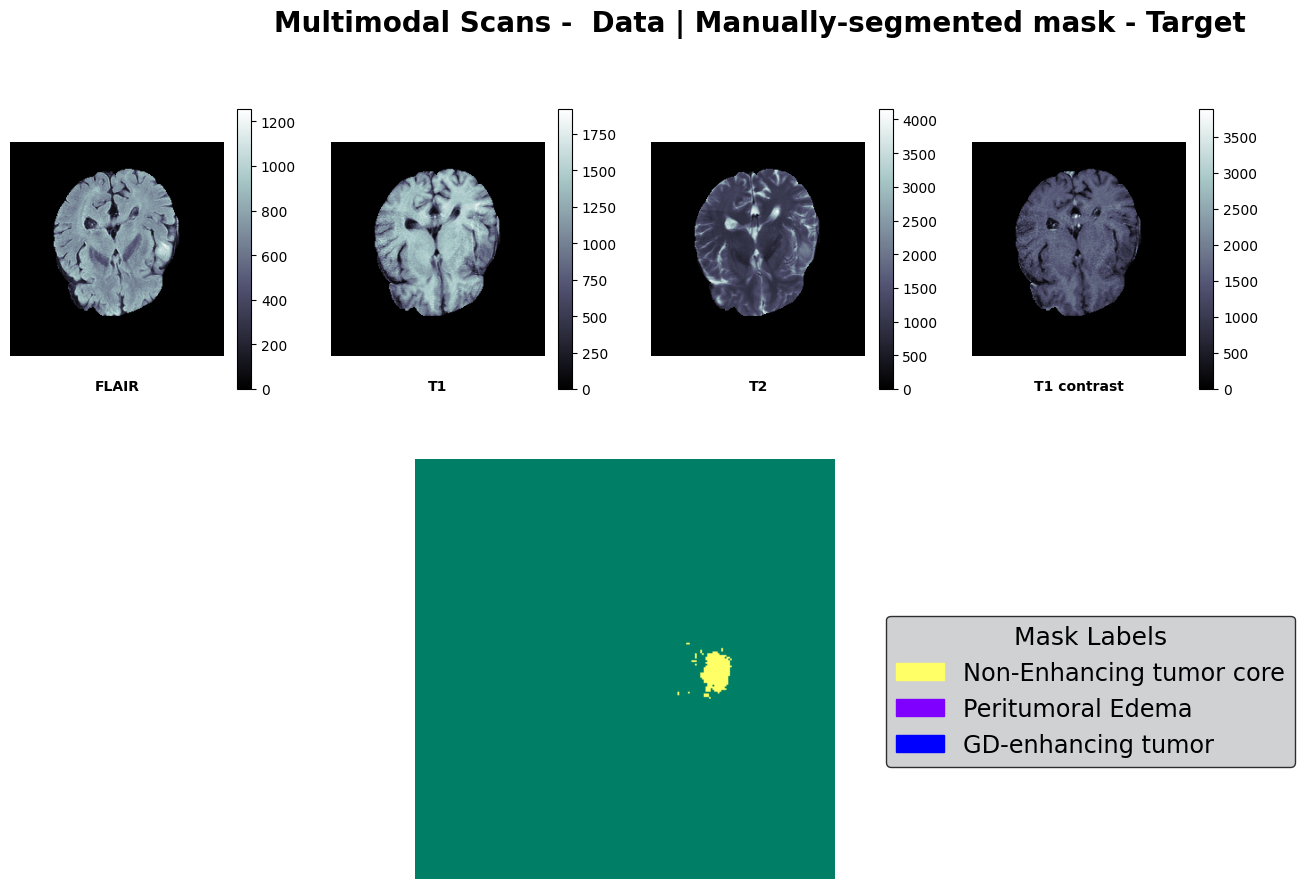

In [ ]:
lenOfData_dir = len(os.listdir(data_dir))
random_value = random.randint(0, lenOfData_dir)
BraTS20_Training_00n = '/'+os.listdir(data_dir)[random_value]
visualize_samples_with_colors(data_dir, BraTS20_Training_00n)

## 3d-unetCreation


In [ ]:
from torch.utils.data import ConcatDataset

# Get patient directories
train_patient_dirs = os.listdir(train_dir)
test_patient_dirs = os.listdir(val_dir)

# Filter only valid directories (patients)
all_train_patients = []
for p in train_patient_dirs:
    if os.path.isdir(os.path.join(train_dir, p)):
        all_train_patients.append(p)
all_train_patients.sort()

all_test_patients = []
for p in test_patient_dirs:
    if os.path.isdir(os.path.join(val_dir, p)):
        all_test_patients.append(p)
all_test_patients.sort()


# For quick testing/debugging, use smaller subset
use_subset = False  # Set to False for full training
if use_subset:
    all_train_patients = get_subset_patients(all_train_patients, ratio=0.2)
    all_test_patients = get_subset_patients(all_test_patients, ratio=0.2)

print(f"Using {len(all_train_patients)} training patients and {len(all_test_patients)} test patients")


# Split training data into train and validation
##add random state
slice_range = (50, 110)

# Split
train_patients, val_patients = train_test_split(all_train_patients, test_size=0.2, random_state=42)

# Augmentation transform
aug_transform = AlbumentationsSliceTransform()

# Dataset senza trasformazioni
train_dataset_original = BrainTumorDataset(
    patient_list=train_patients,
    data_dir=train_dir,
    slice_range=slice_range,
    transform=None
)

# Dataset con trasformazioni
train_dataset_augmented = BrainTumorDataset(
    patient_list=train_patients,
    data_dir=train_dir,
    slice_range=slice_range,
    transform=aug_transform
)

# Unione dei due dataset (doppia dimensione effettiva)
train_dataset = ConcatDataset([train_dataset_original, train_dataset_augmented])

# Validation e Test set invariati
val_dataset = BrainTumorDataset(
    patient_list=val_patients,
    data_dir=train_dir,
    slice_range=slice_range
)

test_dataset = BrainTumorDataset(
    patient_list=all_test_patients,
    data_dir=val_dir,
    is_train=False,
    slice_range=slice_range
)
# DataLoaders with small batch_size but more workers if available
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)

# Check sample data dimensions
sample_img, sample_mask = next(iter(train_loader))
print(f"Train set image dimension: {sample_img.shape}")  # Should be smaller now
print(f"Train set segmentation dimension: {sample_mask.shape}")

sample_img, sample_mask = next(iter(val_loader))
print("Validation set image dimension:", sample_img.shape)
print("Validation set segmentation dimension:", sample_mask.shape)

sample_img = next(iter(test_loader))
print("Test set image dimension:", sample_img.shape)

Using 369 training patients and 125 test patients
Train set image dimension: torch.Size([8, 4, 240, 240, 60])
Train set segmentation dimension: torch.Size([8, 240, 240, 60])
Validation set image dimension: torch.Size([8, 4, 240, 240, 60])
Validation set segmentation dimension: torch.Size([8, 240, 240, 60])
Test set image dimension: torch.Size([8, 4, 240, 240, 60])


In [ ]:
import gc

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    torch.cuda.empty_cache()  # Clear GPU cache before starting
    gc.collect()
    for obj in gc.get_objects():
        if torch.is_tensor(obj):
            del obj
    torch.cuda.empty_cache()
    print(f"Using {num_gpus} GPUs for training." if num_gpus > 1 else
          f"Using {torch.cuda.get_device_name(0)} for training.")
else:
    print("Using CPU for training.")

Using Tesla T4 for training.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ImprovedUNet3D(nn.Module):
    def __init__(self, in_channels=4, out_channels=4, base_filters=16):
        super(ImprovedUNet3D, self).__init__()

        # Encoder path (reduced from 4 to 3 levels)
        self.enc1 = self._make_layer(in_channels, base_filters)
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2)

        self.enc2 = self._make_layer(base_filters, base_filters*2)
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2)

        self.enc3 = self._make_layer(base_filters*2, base_filters*4)
        self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = self._make_layer(base_filters*4, base_filters*8)

        # Decoder path (reduced from 4 to 3 levels)
        self.upconv3 = nn.ConvTranspose3d(base_filters*8, base_filters*4, kernel_size=2, stride=2)
        self.dec3 = self._make_layer(base_filters*8, base_filters*4)

        self.upconv2 = nn.ConvTranspose3d(base_filters*4, base_filters*2, kernel_size=2, stride=2)
        self.dec2 = self._make_layer(base_filters*4, base_filters*2)

        self.upconv1 = nn.ConvTranspose3d(base_filters*2, base_filters, kernel_size=2, stride=2)
        self.dec1 = self._make_layer(base_filters*2, base_filters)

        # Output layer
        self.final_conv = nn.Conv3d(base_filters, out_channels, kernel_size=1)

    def _make_layer(self, in_channels, out_channels):
        """Simplified layer with fewer operations"""
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),  # Using BatchNorm instead of InstanceNorm
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        enc1_out = self.enc1(x)
        p1 = self.pool1(enc1_out)

        enc2_out = self.enc2(p1)
        p2 = self.pool2(enc2_out)

        enc3_out = self.enc3(p2)
        p3 = self.pool3(enc3_out)

        # Bottleneck
        bottleneck_out = self.bottleneck(p3)

        # Decoder with skip connections
        up3 = self.upconv3(bottleneck_out)
        # Simple concatenation instead of custom crop_and_concat
        concat3 = torch.cat([up3, enc3_out], dim=1)
        dec3_out = self.dec3(concat3)

        up2 = self.upconv2(dec3_out)
        concat2 = torch.cat([up2, enc2_out], dim=1)
        dec2_out = self.dec2(concat2)

        up1 = self.upconv1(dec2_out)
        concat1 = torch.cat([up1, enc1_out], dim=1)
        dec1_out = self.dec1(concat1)

        # Final classification layer
        out = self.final_conv(dec1_out)

        return out

In [ ]:
ImprovedUNet3D(in_channels=4, out_channels=4, base_filters=32)

ImprovedUNet3D(
  (enc1): Sequential(
    (0): Conv3d(4, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (pool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (pool2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc3): Sequential(
    (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (pool3): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottleneck): Sequential(
    (0): Conv3d(

In [ ]:
def dice_coefficient(pred, target, num_classes=4, smooth=1e-6):
    dice_scores = []
    for class_id in range(num_classes):
        # Create binary masks for the current class
        pred_class = (pred == class_id).float()    # 1 where pred == class_id, else 0
        target_class = (target == class_id).float()  # 1 where target == class_id, else 0
        # Compute intersection (common positive pixels)
        intersection = (pred_class * target_class).sum()

        # Compute Dice coefficient for the current class
        dice_score = (2. * intersection + smooth) / (pred_class.sum() + target_class.sum() + smooth)
        dice_scores.append(dice_score)

    # Convert list to tensor and return mean Dice score across all classes
    #return torch.mean(torch.tensor(dice_scores))
    dice_scores = torch.stack(dice_scores)  # Usa torch.stack per evitare problemi con i tensori
    return dice_scores.mean()

#which measures overlap between predicted and true segmentation masks
class DiceLoss(nn.Module):
    def __init__(self, num_classes=4, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.num_classes = num_classes
        self.smooth = smooth

    def forward(self, y_pred, y_true):
        print("y_pred shape: ", y_pred.shape)
        print("y_true shape: ", y_true.shape)
        return 1 - dice_coefficient(y_pred, y_true, num_classes=self.num_classes, smooth=self.smooth)


class CombinedLoss(nn.Module):
    def __init__(self, weight_dice=0.7, weight_ce=0.3, num_classes=4):
        super(CombinedLoss, self).__init__()
        self.weight_dice = weight_dice
        self.weight_ce = weight_ce
        self.dice_loss = DiceLoss(num_classes=num_classes)
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, inputs, targets):
        # Cross entropy component
        ce_loss = self.ce_loss(inputs, targets)

        # Calcolare la Dice Loss
        dice_loss_value = self.dice_loss(inputs, targets)

        # Combinare le due perdite
        return self.weight_ce * ce_loss + self.weight_dice * dice_loss_value

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Modified dice_coefficient for Soft Dice (expects probabilities)
def dice_coefficient_soft(pred_probs, target, num_classes=4, smooth=1e-6):
    dice_scores = []
    # Convert target labels to one-hot encoding
    # Target shape: [B, D, H, W], Num classes: C
    # Output target_one_hot shape: [B, C, D, H, W]
    target_one_hot = F.one_hot(target, num_classes=num_classes).permute(0, 4, 1, 2, 3).float()
    # pred_probs shape should be [B, C, D, H, W] (after softmax)

    for class_id in range(num_classes):
        pred_class = pred_probs[:, class_id, ...]
        target_class = target_one_hot[:, class_id, ...]
        # Compute intersection (sum of element-wise product)
        intersection = (pred_class * target_class).sum(dim=[1, 2, 3]) # Sum over spatial dims

        # Compute sum of probabilities for pred and target
        pred_sum = pred_class.sum(dim=[1, 2, 3])
        target_sum = target_class.sum(dim=[1, 2, 3])

        # Compute Dice coefficient for the current class for each item in the batch
        dice_score_class = (2. * intersection + smooth) / (pred_sum + target_sum + smooth)

        # Average dice score across the batch for this class
        dice_scores.append(dice_score_class.mean()) # Take mean over batch dimension

    # Convert list to tensor and return mean Dice score across all classes
    dice_scores = torch.stack(dice_scores)
    return dice_scores.mean() # Mean dice across classes

# Modified DiceLoss using Soft Dice
class DiceLoss(nn.Module):
    def __init__(self, num_classes=4, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.num_classes = num_classes
        self.smooth = smooth

    def forward(self, y_pred_logits, y_true):
        # Apply Softmax to get probabilities
        y_pred_probs = F.softmax(y_pred_logits, dim=1)
        # Calculate soft dice coefficient
        dice = dice_coefficient_soft(y_pred_probs, y_true, num_classes=self.num_classes, smooth=self.smooth)
        return 1 - dice

# CombinedLoss remains structurally the same, but now uses the corrected DiceLoss
class CombinedLoss(nn.Module):
    def __init__(self, weight_dice=0.7, weight_ce=0.3, num_classes=4):
        super(CombinedLoss, self).__init__()
        self.weight_dice = weight_dice
        self.weight_ce = weight_ce
        # Use the NEW DiceLoss implementation
        self.dice_loss = DiceLoss(num_classes=num_classes)
        # Ignore index can be useful if you have background pixels you want CE to ignore
        self.ce_loss = nn.CrossEntropyLoss() # Add ignore_index=0 if background is class 0 and should be ignored by CE

    def forward(self, inputs_logits, targets):
        ce_loss_value = self.ce_loss(inputs_logits, targets)
        dice_loss_value = self.dice_loss(inputs_logits, targets)
        return self.weight_ce * ce_loss_value + self.weight_dice * dice_loss_value

# --- Your existing dice_coefficient for METRIC calculation ---
# Keep this version for calculating the validation metric using argmax predictions
def dice_coefficient_metric(pred_labels, target_labels, num_classes=4, smooth=1e-6):
    dice_scores = []
    for class_id in range(num_classes):
        pred_class = (pred_labels == class_id).float()
        target_class = (target_labels == class_id).float()
        intersection = (pred_class * target_class).sum()
        dice_score = (2. * intersection + smooth) / (pred_class.sum() + target_class.sum() + smooth)
        #print(f"Dice score for class {class_id}: {dice_score}")
        dice_scores.append(dice_score)
    dice_scores = torch.stack(dice_scores)
    return dice_scores.mean()


In [ ]:
# Initialize model with improved architecture
model = ImprovedUNet3D(in_channels=4, out_channels=4, base_filters=32)
model = model.to(device)

# Use mixed precision for memory efficiency
use_amp = True
scaler = torch.amp.GradScaler("cuda", enabled="use_amp")
criterion = CombinedLoss(weight_dice=0.6, weight_ce=0.4, num_classes=4)
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-6)

In [ ]:
# Function to train for one epoch with memory optimization
def train_one_epoch(model, dataloader, optimizer, criterion, device, scaler=None):
    model.train()
    epoch_loss = 0.0
    dice_score = 0.0
    batch_count = 0
    for i, (inputs, targets) in enumerate(dataloader):
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass with mixed precision
        if use_amp:
            with torch.amp.autocast('cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, targets)

            # Backward pass with gradient scaling
            scaler.scale(loss).backward()

            # Gradient clipping to prevent exploding gradients
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            scaler.step(optimizer)
            scaler.update()
        else:
            # Standard forward and backward pass
            outputs = model(inputs)
            print(outputs.shape)
            print(targets.shape)

            loss = criterion(outputs, targets)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

        # Update metrics
        epoch_loss += loss.item()

        # Get predictions
        if outputs.shape[1] > 1:  # Multi-class case
            _, preds = torch.max(outputs, 1)
        else:  # Binary case
            preds = (torch.sigmoid(outputs) > 0.5).float()

        # Calculate Dice score using the predictions (not logits)
        dice = dice_coefficient_metric(preds, targets)
        dice_score += dice.item()
        batch_count += 1

        # Print progress
        if (i+1) % 5 == 0:
            print(f"Batch {i+1}/{len(dataloader)}, Loss: {loss.item():.4f}, Dice: {dice:.4f}")

        # Free up memory
        del inputs, targets, outputs, preds
        torch.cuda.empty_cache()

    # Calculate average metrics
    avg_loss = epoch_loss / batch_count
    avg_dice = dice_score / batch_count

    return avg_loss, avg_dice


# Validation loop
def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    epoch_loss = 0.0
    dice_score = 0.0
    batch_count = 0

    with torch.no_grad():
        for i, (inputs, targets) in enumerate(dataloader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            # Forward pass
            if use_amp:
                with torch.cuda.amp.autocast():
                    outputs = model(inputs) # Logits
                    loss = criterion(outputs, targets) # Uses CombinedLoss with SoftDice
            else:
                outputs = model(inputs) # Logits
                loss = criterion(outputs, targets) # Uses CombinedLoss with SoftDice

            epoch_loss += loss.item()

            if outputs.shape[1] > 1:
                _, preds = torch.max(outputs, 1) # Get integer class labels for metric
            else:
                preds = (torch.sigmoid(outputs) > 0.5).float() # For binary case

            # Use the original metric function here
            dice = dice_coefficient_metric(preds, targets, num_classes=4) # Use the metric version
            dice_score += dice.item()
            batch_count += 1

            # Free up memory
            del inputs, targets, outputs, preds
            torch.cuda.empty_cache()

    # Calculate average metrics
    avg_loss = epoch_loss / batch_count
    avg_dice = dice_score / batch_count

    return avg_loss, avg_dice

# Early stopping implementation
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0

In [ ]:
from huggingface_hub import HfApi, create_repo
import os
from datetime import datetime
from google.colab import userdata

# Using HugginFace to retrieve model weights to achieve longer training session
hf_token = userdata.get('HF_TOKEN')
repo_name = "dugoalberto/bratsBottleneck"
api = HfApi()
checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

## Training (from new model)

In [ ]:
# Training loop with early stopping
num_epochs = 120  # Increased epochs with early stopping
best_val_dice = 0.0
early_stopping = EarlyStopping(patience=10)

# Lists to store metrics
train_losses = []
val_losses = []
train_dice_scores = []
val_dice_scores = []
learning_rates = []

for epoch in range(num_epochs):
    print(f"Epoch [{epoch+1}/{num_epochs}]")

    # Train
    train_loss, train_dice = train_one_epoch(model, train_loader, optimizer, criterion, device, scaler)
    train_losses.append(train_loss)
    train_dice_scores.append(train_dice)

    # Update learning rate
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)
    scheduler.step()

    # Free memory before validation
    torch.cuda.empty_cache()

    # Validate
    val_loss, val_dice = validate_one_epoch(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_dice_scores.append(val_dice)

    # Print epoch results
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Dice: {val_dice:.4f}, LR: {current_lr:.6f}")

    if val_dice > best_val_dice:
        best_val_dice = val_dice
        best_model_path = os.path.join(checkpoint_dir, 'BratsCV_best.pt')
        torch.save(model, best_model_path)
        print(f"Best model saved with Dice score: {best_val_dice:.4f}!")

        # Upload best model to Hugging Face
        api.upload_file(
            path_or_fileobj=best_model_path,
            path_in_repo="BratsCV_best.pt",
            repo_id=repo_name,
            token=hf_token
        )
        print(f"Best model uploaded to Hugging Face!")

    # Save regular checkpoint every 5 epochs or final epoch
    if (epoch + 1) % 5 == 0 or epoch == num_epochs - 1:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        checkpoint_path = os.path.join(checkpoint_dir, f'BratsCV_epoch_{epoch+1}_{timestamp}.pt')

        # Save model state dictionary and optimizer state
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_dice': train_dice,
            'val_dice': val_dice,
            'best_val_dice': best_val_dice,
            'learning_rate': current_lr
        }
        torch.save(checkpoint, checkpoint_path)

        # Upload checkpoint to Hugging Face
        try:
            api.upload_file(
                path_or_fileobj=checkpoint_path,
                path_in_repo=f"checkpoints/BratsCV_epoch_{epoch+1}.pt",
                repo_id=repo_name,
                token=hf_token
            )
            print(f"Checkpoint for epoch {epoch+1} uploaded to Hugging Face!")
        except Exception as e:
            print(f"Error uploading checkpoint to Hugging Face: {e}")

    # Check for early stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print(f"Early stopping triggered after {epoch+1} epochs!")

        # Save final model after early stopping
        final_model_path = os.path.join(checkpoint_dir, 'BratsCV_final.pt')
        torch.save(model, final_model_path)

        # Upload final model to Hugging Face
        api.upload_file(
            path_or_fileobj=final_model_path,
            path_in_repo="BratsCV_final.pt",
            repo_id=repo_name,
            token=hf_token
        )
        print("Final model uploaded to Hugging Face!")
        break

    # Free memory after each epoch
    torch.cuda.empty_cache()

# Plot training and validation metrics
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_dice_scores, label='Train Dice')
plt.plot(val_dice_scores, label='Validation Dice')
plt.title('Dice Score')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(learning_rates)
plt.title('Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('LR')

plt.tight_layout()
plt.savefig('training_metrics.png')
plt.show()

print(f"Training completed! Best validation Dice score: {best_val_dice:.4f}")

Epoch [1/120]


OutOfMemoryError: CUDA out of memory. Tried to allocate 422.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 328.12 MiB is free. Process 4055 has 14.42 GiB memory in use. Of the allocated memory 14.23 GiB is allocated by PyTorch, and 71.24 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## Training (from restored model)

In [ ]:
# Nome del checkpoint da recuperare
checkpoint_filename = "checkpoints/BratsCV_epoch_15.pt"
repo_name = "dugoalberto/CVBRATS_p4"
local_checkpoint_path = api.hf_hub_download(
        repo_id=repo_name,
        filename=checkpoint_filename,
        token=hf_token
)
checkpoint = torch.load(local_checkpoint_path, map_location=torch.device('cpu'))

# Verifica i parametri recuperati

BratsCV_epoch_15.pt:   0%|          | 0.00/207M [00:00<?, ?B/s]

In [ ]:
local_checkpoint_path

'/root/.cache/huggingface/hub/models--dugoalberto--BratsCVDeeper/snapshots/4ec5f1702de2e20b311552b2da476f509f7a1ad2/checkpoints/BratsCV_epoch_105.pt'

In [ ]:
# Verifica i parametri recuperati
print("Checkpoint Recovery Information:")
print("-" * 40)

# Stampa informazioni sull'epoch
print(f"Epoch: {checkpoint.get('epoch', 'Not found')}")

# Stampa metriche
print(f"Training Loss: {checkpoint.get('train_loss', 'Not found')}")
print(f"Validation Loss: {checkpoint.get('val_loss', 'Not found')}")
print(f"Training Dice Score: {checkpoint.get('train_dice', 'Not found')}")
print(f"Validation Dice Score: {checkpoint.get('val_dice', 'Not found')}")
print(f"Best Validation Dice Score: {checkpoint.get('best_val_dice', 'Not found')}")

Checkpoint Recovery Information:
----------------------------------------
Epoch: 15
Training Loss: 0.16727075946903755
Validation Loss: 0.1599167888178616
Training Dice Score: 0.7631485280739206
Validation Dice Score: 0.7720904273761285
Best Validation Dice Score: 0.7720904273761285


In [ ]:
model = ImprovedUNet3D(in_channels=4, out_channels=4, base_filters=32)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)

# Ricreate the parameters fro the fetched model
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=5e-5)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-6)

if checkpoint['scheduler_state_dict']:
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

num_epochs = 300  # Increased epochs with early stopping
start_epoch = checkpoint['epoch']
early_stopping = EarlyStopping(patience=10)

scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

# Lists to store metrics
train_losses = []
val_losses = []
train_dice_scores = []
val_dice_scores = []
learning_rates = []

best_val_dice = checkpoint['best_val_dice']

# Restart the training
for epoch in range(start_epoch, num_epochs):
    print(f"Epoch [{epoch+1}/{num_epochs}]")

    # Train
    train_loss, train_dice = train_one_epoch(model, train_loader, optimizer, criterion, device, scaler)
    train_losses.append(train_loss)
    train_dice_scores.append(train_dice)

    # Update learning rate
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)
    scheduler.step()

    # Free memory before validation
    torch.cuda.empty_cache()

    # Validate
    val_loss, val_dice = validate_one_epoch(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_dice_scores.append(val_dice)

    # Print epoch results
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Dice: {val_dice:.4f}, LR: {current_lr:.6f}")

    if val_dice > best_val_dice:
        best_val_dice = val_dice
        best_model_path = os.path.join(checkpoint_dir, 'BratsCV_best.pt')
        torch.save(model, best_model_path)
        print(f"Best model saved with Dice score: {best_val_dice:.4f}!")

        # Upload best model to Hugging Face
        api.upload_file(
            path_or_fileobj=best_model_path,
            path_in_repo="BratsCV_best.pt",
            repo_id=repo_name,
            token=hf_token
        )
        print(f"Best model uploaded to Hugging Face!")

    # Save regular checkpoint every 5 epochs or final epoch
    if (epoch + 1) % 5 == 0 or epoch == num_epochs - 1:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        checkpoint_path = os.path.join(checkpoint_dir, f'BratsCV_epoch_{epoch+1}_{timestamp}.pt')

        # Save model state dictionary and optimizer state
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_dice': train_dice,
            'val_dice': val_dice,
            'best_val_dice': best_val_dice,
            'learning_rate': current_lr
        }
        torch.save(checkpoint, checkpoint_path)

        # Upload checkpoint to Hugging Face
        try:
            api.upload_file(
                path_or_fileobj=checkpoint_path,
                path_in_repo=f"checkpoints/BratsCV_epoch_{epoch+1}.pt",
                repo_id=repo_name,
                token=hf_token
            )
            print(f"Checkpoint for epoch {epoch+1} uploaded to Hugging Face!")
        except Exception as e:
            print(f"Error uploading checkpoint to Hugging Face: {e}")

    # Check for early stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print(f"Early stopping triggered after {epoch+1} epochs!")

        # Save final model after early stopping
        final_model_path = os.path.join(checkpoint_dir, 'BratsCV_final.pt')
        torch.save(model, final_model_path)

        # Upload final model to Hugging Face
        api.upload_file(
            path_or_fileobj=final_model_path,
            path_in_repo="BratsCV_final.pt",
            repo_id=repo_name,
            token=HF_TOKEN
        )
        print("Final model uploaded to Hugging Face!")
        break

    # Free memory after each epoch
    torch.cuda.empty_cache()

Epoch [16/300]


<ipython-input-52-44e4c448a636>:17: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


Batch 5/588, Loss: 0.1101, Dice: 0.8473
Batch 10/588, Loss: 0.3086, Dice: 0.5083
Batch 15/588, Loss: 0.2532, Dice: 0.5930
Batch 20/588, Loss: 0.0628, Dice: 0.9173
Batch 25/588, Loss: 0.1820, Dice: 0.7595
Batch 30/588, Loss: 0.2616, Dice: 0.5906
Batch 35/588, Loss: 0.1208, Dice: 0.8369
Batch 40/588, Loss: 0.2131, Dice: 0.6884
Batch 45/588, Loss: 0.1109, Dice: 0.8736
Batch 50/588, Loss: 0.1706, Dice: 0.7424
Batch 55/588, Loss: 0.1089, Dice: 0.8342
Batch 60/588, Loss: 0.1539, Dice: 0.7715
Batch 65/588, Loss: 0.1552, Dice: 0.7605
Batch 70/588, Loss: 0.2343, Dice: 0.6379
Batch 75/588, Loss: 0.1056, Dice: 0.8900
Batch 80/588, Loss: 0.2852, Dice: 0.6429
Batch 85/588, Loss: 0.0809, Dice: 0.8835
Batch 90/588, Loss: 0.0630, Dice: 0.9211
Batch 95/588, Loss: 0.1048, Dice: 0.8494
Batch 100/588, Loss: 0.1278, Dice: 0.8234
Batch 105/588, Loss: 0.3095, Dice: 0.6060
Batch 110/588, Loss: 0.1051, Dice: 0.8730
Batch 115/588, Loss: 0.2828, Dice: 0.5607
Batch 120/588, Loss: 0.1154, Dice: 0.8170
Batch 125/58

<ipython-input-43-6d8ba6f13539>:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [16/300], Train Loss: 0.1632, Train Dice: 0.7670
Validation Loss: 0.1498, Validation Dice: 0.7849, LR: 0.000251
Best model saved with Dice score: 0.7849!


BratsCV_best.pt:   0%|          | 0.00/185M [00:00<?, ?B/s]

Best model uploaded to Hugging Face!
Epoch [17/300]
Batch 5/588, Loss: 0.0973, Dice: 0.9021
Batch 10/588, Loss: 0.2402, Dice: 0.6805
Batch 15/588, Loss: 0.1834, Dice: 0.7695
Batch 20/588, Loss: 0.0481, Dice: 0.9369
Batch 25/588, Loss: 0.2017, Dice: 0.7413
Batch 30/588, Loss: 0.1073, Dice: 0.8695
Batch 35/588, Loss: 0.1474, Dice: 0.7908
Batch 40/588, Loss: 0.1371, Dice: 0.7903
Batch 45/588, Loss: 0.2222, Dice: 0.6475
Batch 50/588, Loss: 0.1193, Dice: 0.8100
Batch 55/588, Loss: 0.2276, Dice: 0.7233
Batch 60/588, Loss: 0.0571, Dice: 0.9223
Batch 65/588, Loss: 0.1698, Dice: 0.7910
Batch 70/588, Loss: 0.2475, Dice: 0.6985
Batch 75/588, Loss: 0.1008, Dice: 0.8683
Batch 80/588, Loss: 0.1492, Dice: 0.7703
Batch 85/588, Loss: 0.0486, Dice: 0.9281
Batch 90/588, Loss: 0.1067, Dice: 0.8513
Batch 95/588, Loss: 0.2118, Dice: 0.7002
Batch 100/588, Loss: 0.2375, Dice: 0.6125
Batch 105/588, Loss: 0.2072, Dice: 0.6705
Batch 110/588, Loss: 0.0863, Dice: 0.8729
Batch 115/588, Loss: 0.1000, Dice: 0.8542
Ba

## Evaluation and Prediction

In [ ]:
from natsort import natsorted ###Matteo: aggiunto per fare l'ordinamento naturale

# Recupera i checkpoint da Hugging Face
def download_all_checkpoints(repo_name, checkpoint_dir):
    checkpoints = []

    # Trova tutti i checkpoint nel repository
    files = api.list_repo_files(repo_id=repo_name)
    checkpoint_files = [f for f in files if f.startswith('checkpoints/') and f.endswith('.pt')]

    # Ordina i checkpoint per nome (che dovrebbe contenere l'epoch)
    checkpoint_files = natsorted(checkpoint_files)

    # Scarica tutti i checkpoint
    for checkpoint_file in checkpoint_files:
        try:
            local_path = api.hf_hub_download(
                repo_id=repo_name,
                filename=checkpoint_file,
                #token=HF_TOKEN

            )
            checkpoint = torch.load(local_path, map_location=torch.device('cpu'))
            checkpoints.append(checkpoint)
        except Exception as e:
            print(f"Error downloading {checkpoint_file}: {e}")

    return checkpoints

In [ ]:
# Download best model
files = api.list_repo_files(repo_id=repo_name)
best_model = [f for f in files if f.startswith('BratsCV_best.pt')][0]

BratsCV_epoch_5.pt:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

BratsCV_epoch_10.pt:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

BratsCV_epoch_15.pt:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

BratsCV_epoch_20.pt:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

BratsCV_epoch_25.pt:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

BratsCV_epoch_30.pt:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

BratsCV_epoch_35.pt:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

BratsCV_epoch_40.pt:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

BratsCV_epoch_45.pt:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

BratsCV_epoch_50.pt:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

BratsCV_epoch_55.pt:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

BratsCV_epoch_60.pt:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

BratsCV_epoch_65.pt:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

BratsCV_epoch_70.pt:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

BratsCV_epoch_75.pt:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

BratsCV_epoch_85.pt:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

BratsCV_epoch_90.pt:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

BratsCV_epoch_95.pt:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

BratsCV_epoch_100.pt:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

BratsCV_epoch_105.pt:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

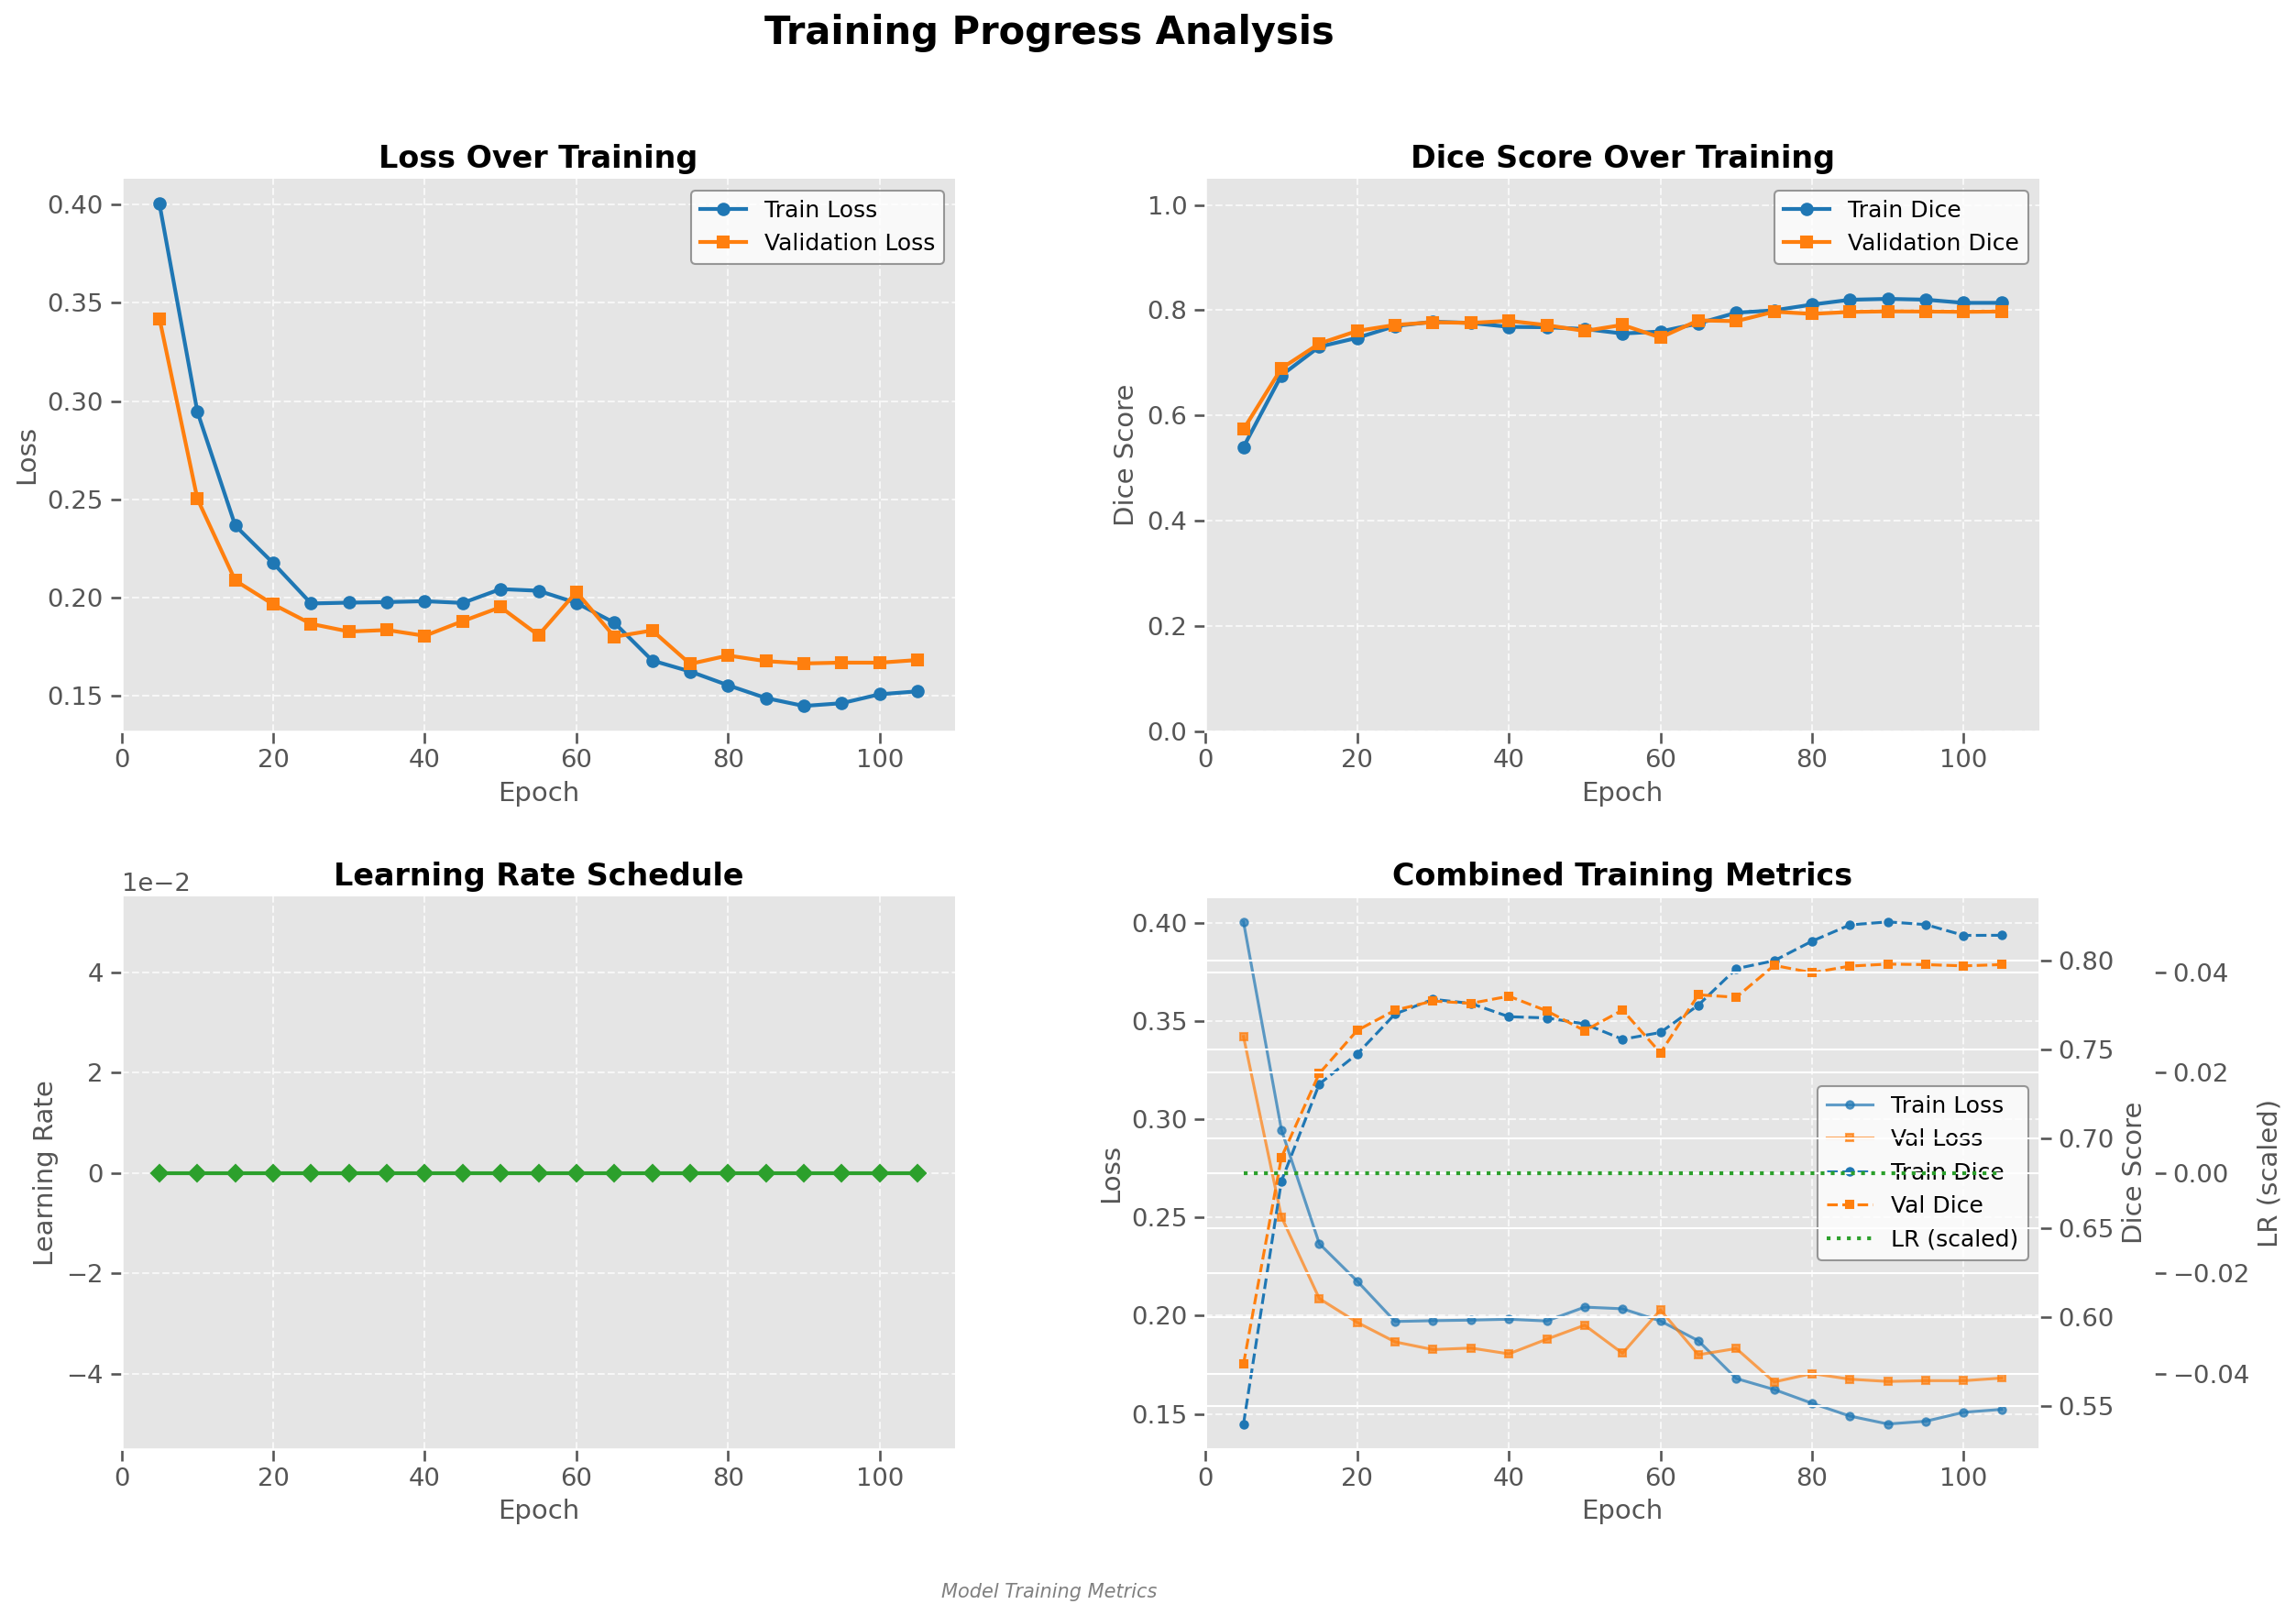

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set a professional style
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.2)

# Recupera tutti i checkpoint
checkpoints = download_all_checkpoints(repo_name, checkpoint_dir)
progression = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105]

# Estrai le metriche dai checkpoint
train_losses = []
val_losses = []
train_dice_scores = []
val_dice_scores = []
learning_rates = []
epochs = []

for checkpoint in checkpoints:
    # Recupera le metriche, con fallback se non esistono
    train_losses.extend(checkpoint.get('train_losses', [checkpoint.get('train_loss', 0)]))
    val_losses.extend(checkpoint.get('val_losses', [checkpoint.get('val_loss', 0)]))
    train_dice_scores.extend(checkpoint.get('train_dice_scores', [checkpoint.get('train_dice', 0)]))
    val_dice_scores.extend(checkpoint.get('val_dice_scores', [checkpoint.get('val_dice', 0)]))
    learning_rates.extend(checkpoint.get('learning_rates', [0]))
    # Recupera gli epoch
    epochs.append(checkpoint.get('epoch', 0))

# Create a figure with appropriate size and DPI for better quality
fig = plt.figure(figsize=(18, 12), dpi=150)

# Define consistent colors
train_color = '#1f77b4'  # Blue
val_color = '#ff7f0e'    # Orange
lr_color = '#2ca02c'     # Green

# Create grid for plots
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# Loss plot
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(progression, train_losses, marker='o', linestyle='-', linewidth=2, color=train_color, label='Train Loss')
ax1.plot(progression, val_losses, marker='s', linestyle='-', linewidth=2, color=val_color, label='Validation Loss')
ax1.set_title('Loss Over Training', fontsize=16, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=14)
ax1.set_ylabel('Loss', fontsize=14)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend(fontsize=12, frameon=True, facecolor='white', edgecolor='gray')
ax1.set_xlim(0, max(progression) + 5)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Dice score plot
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(progression, train_dice_scores, marker='o', linestyle='-', linewidth=2, color=train_color, label='Train Dice')
ax2.plot(progression, val_dice_scores, marker='s', linestyle='-', linewidth=2, color=val_color, label='Validation Dice')
ax2.set_title('Dice Score Over Training', fontsize=16, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=14)
ax2.set_ylabel('Dice Score', fontsize=14)
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.legend(fontsize=12, frameon=True, facecolor='white', edgecolor='gray')
ax2.set_xlim(0, max(progression) + 5)
ax2.set_ylim(0, 1.05)  # Assuming Dice score ranges from 0 to 1
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Learning rate plot
ax3 = fig.add_subplot(gs[1, 0])
ax3.plot(progression, learning_rates, marker='D', linestyle='-', linewidth=2, color=lr_color)
ax3.set_title('Learning Rate Schedule', fontsize=16, fontweight='bold')
ax3.set_xlabel('Epoch', fontsize=14)
ax3.set_ylabel('Learning Rate', fontsize=14)
ax3.grid(True, linestyle='--', alpha=0.7)
ax3.set_xlim(0, max(progression) + 5)
# Use scientific notation for small values
ax3.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

# Combined metrics plot
ax4 = fig.add_subplot(gs[1, 1])
# Normalized learning rate for comparison (scaled to be visible with other metrics)
max_dice = max(max(train_dice_scores), max(val_dice_scores)) if train_dice_scores and val_dice_scores else 1.0
max_lr = max(learning_rates) if learning_rates else 1.0

# Safety check to avoid division by zero
if max_lr > 0:
    lr_normalized = [lr / max_lr * max_dice * 0.5 for lr in learning_rates]
else:
    # If all learning rates are zero, just use zeros
    lr_normalized = [0] * len(learning_rates)

lines = []
lines.append(ax4.plot(progression, train_losses, marker='o', markersize=4, linestyle='-',
             color=train_color, alpha=0.7, label='Train Loss')[0])
lines.append(ax4.plot(progression, val_losses, marker='s', markersize=4, linestyle='-',
             color=val_color, alpha=0.7, label='Val Loss')[0])

ax4_twin = ax4.twinx()
lines.append(ax4_twin.plot(progression, train_dice_scores, marker='o', markersize=4, linestyle='--',
              color=train_color, label='Train Dice')[0])
lines.append(ax4_twin.plot(progression, val_dice_scores, marker='s', markersize=4, linestyle='--',
              color=val_color, label='Val Dice')[0])

ax4_twin2 = ax4.twinx()
# Offset the second y-axis to be on the right
ax4_twin2.spines['right'].set_position(('outward', 60))
lines.append(ax4_twin2.plot(progression, lr_normalized, linestyle=':', linewidth=2,
               color=lr_color, label='LR (scaled)')[0])

ax4.set_title('Combined Training Metrics', fontsize=16, fontweight='bold')
ax4.set_xlabel('Epoch', fontsize=14)
ax4.set_ylabel('Loss', fontsize=14)
ax4_twin.set_ylabel('Dice Score', fontsize=14)
ax4_twin2.set_ylabel('LR (scaled)', fontsize=14)
ax4.grid(True, linestyle='--', alpha=0.7)
ax4.set_xlim(0, max(progression) + 5)

# Add a combined legend
labels = [l.get_label() for l in lines]
ax4.legend(lines, labels, loc='center right', fontsize=12, frameon=True, facecolor='white', edgecolor='gray')

# Add a title for the entire figure
fig.suptitle('Training Progress Analysis', fontsize=20, fontweight='bold', y=0.98)

# Add a subtle watermark (optional)
fig.text(0.5, 0.02, 'Model Training Metrics', fontsize=10, color='gray', ha='center', style='italic')

# Save with high quality
plt.savefig('enhanced_training_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
torch.serialization.add_safe_globals([ImprovedUNet3D, nn.Sequential, nn.InstanceNorm3d, nn.LeakyReLU, nn.Dropout3d, nn.Conv3d, nn.MaxPool3d, nn.ConvTranspose3d])

model_path = os.path.join(checkpoint_dir, 'BratsCV_best.pt')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedUNet3D()  # o con i parametri se ne ha
model = torch.load(local_checkpoint_path, map_location=device)
#model = model.to(device)
model.eval()

AttributeError: 'dict' object has no attribute 'eval'

In [ ]:
# 1. Ricrea il modello
model = ImprovedUNet3D()  # o con i parametri se ne ha
model = model.to(device)

# 2. Carica il dizionario
checkpoint = torch.load(local_checkpoint_path, map_location=device)

# 3. Carica i pesi nel modello
model.load_state_dict(checkpoint['model_state_dict'])

# 4. Imposta in modalità evaluation
model.eval()


ImprovedUNet3D(
  (enc1): Sequential(
    (0): Conv3d(4, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (7): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (8): LeakyReLU(negative_slope=0.01, inplace=True)
    (9): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (10): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (11): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (pool1): MaxPool3d(kernel_s

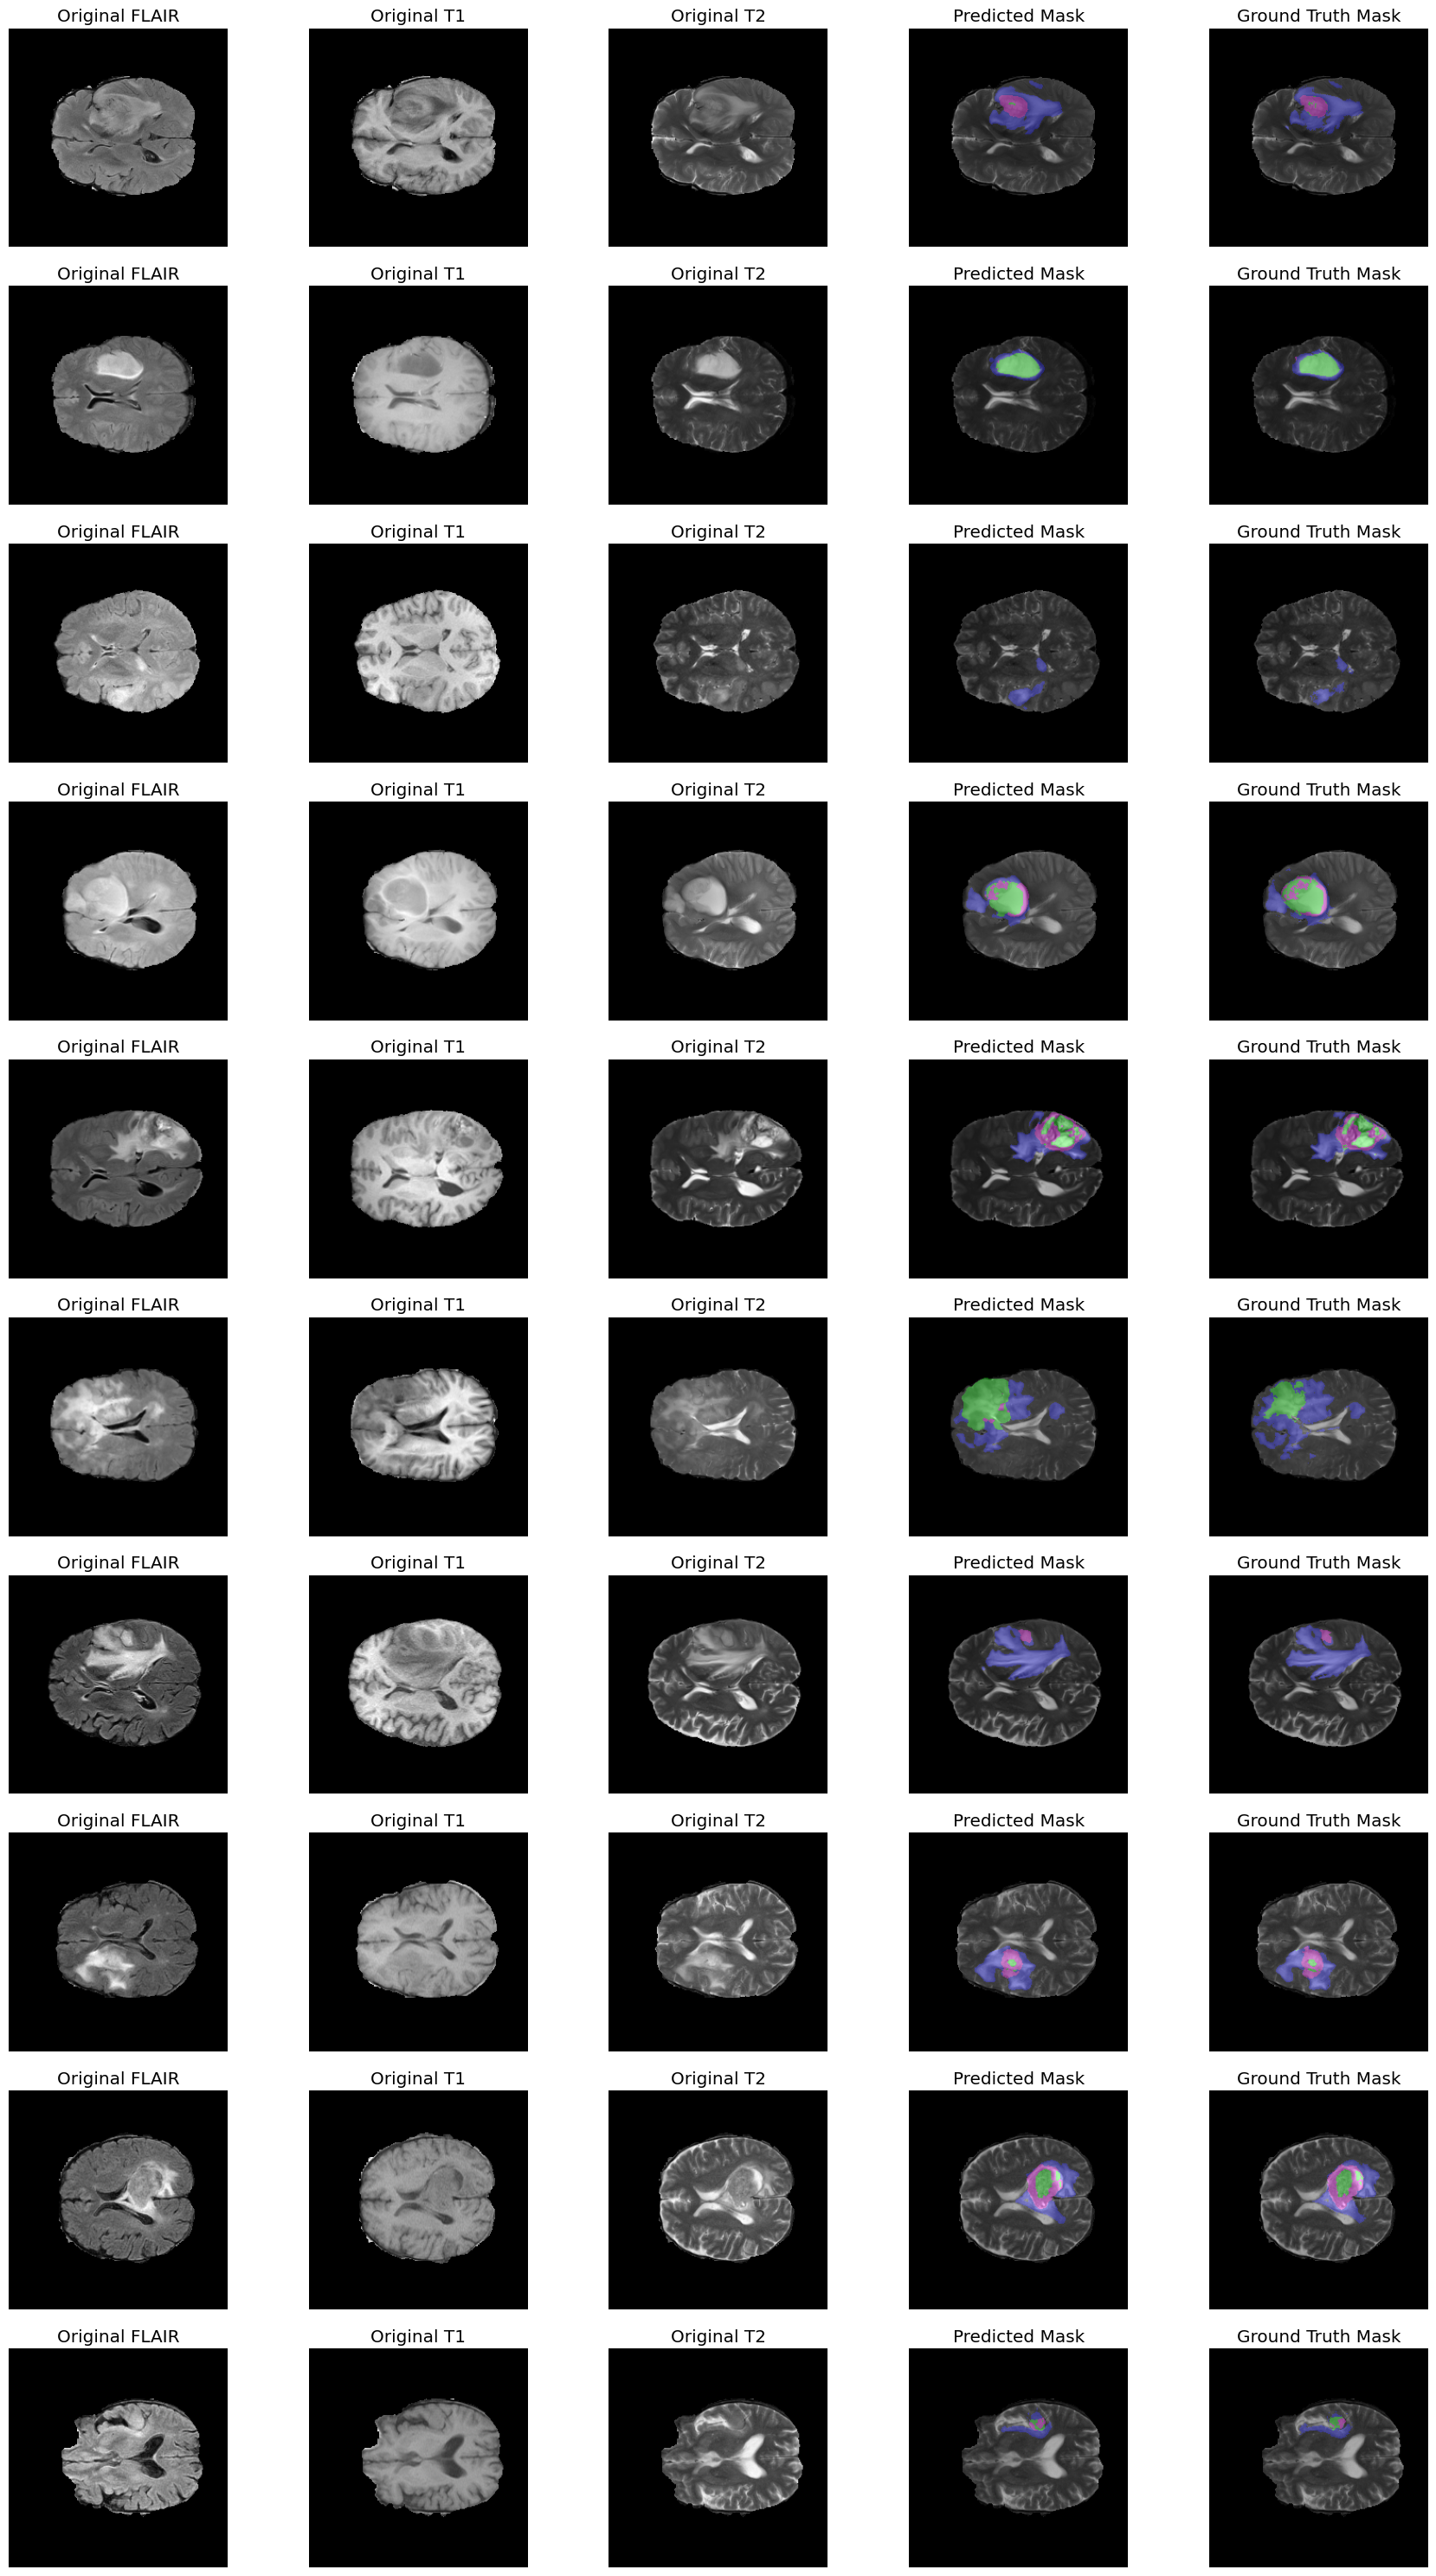

In [ ]:
# Take random 10 images
test_iter = iter(val_loader)
num_images = 10
fig, axes = plt.subplots(num_images, 5, figsize=(18, num_images * 3))  # Changed from 4 to 5 columns

for i in range(num_images):
    # Get next sample with both image and ground truth
    sample = next(test_iter)
    test_image = sample[0].to(device)  # Assuming this is the image data (1, 4, H, W, D)
    gt_mask = sample[1].to(device)     # Assuming this is the ground truth mask (1, H, W, D)

    # Prediction with model
    with torch.no_grad():
        output = model(test_image)  # (1, 2, H, W, D)
        prediction = torch.argmax(output, dim=1).cpu().numpy()  # (1, H, W, D)

    # Transform to numpy
    test_image_np = test_image.cpu().numpy()
    gt_mask_np = gt_mask.cpu().numpy()  # Convert ground truth to numpy

    # Select middle slice (e.g. D/2)
    slice_idx = test_image_np.shape[4] // 2  # Depth axis D
    flair_slice = test_image_np[0, 0, :, :, slice_idx]  # flair modality
    t1_slice = test_image_np[0, 1, :, :, slice_idx]  # T1 modality
    t2_slice = test_image_np[0, 3, :, :, slice_idx]  # T2 modality
    pred_mask = prediction[0, :, :, slice_idx]  # Predicted segmentation mask
    gt_slice = gt_mask_np[0, :, :, slice_idx]   # Ground truth slice

    # Normalize and convert to 8-bit (For Image)
    flair_slice = cv2.normalize(flair_slice, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    t1_slice = cv2.normalize(t1_slice, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    t2_slice = cv2.normalize(t2_slice, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Make it colorful
    flair_colored = cv2.cvtColor(flair_slice, cv2.COLOR_GRAY2BGR)
    t1_colored = cv2.cvtColor(t1_slice, cv2.COLOR_GRAY2BGR)
    t2_colored = cv2.cvtColor(t2_slice, cv2.COLOR_GRAY2BGR)

    # Color the segmentation masks (both predicted and ground truth)
    pred_mask_colored = np.zeros_like(t2_colored)
    gt_mask_colored = np.zeros_like(t2_colored)

    # Define colors for each class
    colors = {
        0: [0, 0, 0],     # Background: black
        1: [0, 255, 0],   # Class 1: green
        2: [0, 0, 255],   # Class 2: blue
        3: [255, 0, 255]  # Class 3: magenta
    }

    # Assign colors to pixels in both masks
    for class_idx, color in colors.items():
        pred_mask_colored[pred_mask == class_idx] = color
        gt_mask_colored[gt_slice == class_idx] = color

    # Overlay segmentation transparently onto image
    pred_blended = cv2.addWeighted(t2_colored, 0.7, pred_mask_colored, 0.3, 0)
    gt_blended = cv2.addWeighted(t2_colored, 0.7, gt_mask_colored, 0.3, 0)

    # Draw images
    axes[i, 0].imshow(flair_colored)
    axes[i, 0].set_title("Original FLAIR")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(t1_colored)
    axes[i, 1].set_title("Original T1")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(t2_colored)
    axes[i, 2].set_title("Original T2")
    axes[i, 2].axis("off")

    axes[i, 3].imshow(pred_blended)
    axes[i, 3].set_title("Predicted Mask")
    axes[i, 3].axis("off")

    axes[i, 4].imshow(gt_blended)
    axes[i, 4].set_title("Ground Truth Mask")
    axes[i, 4].axis("off")

plt.tight_layout()
plt.show()

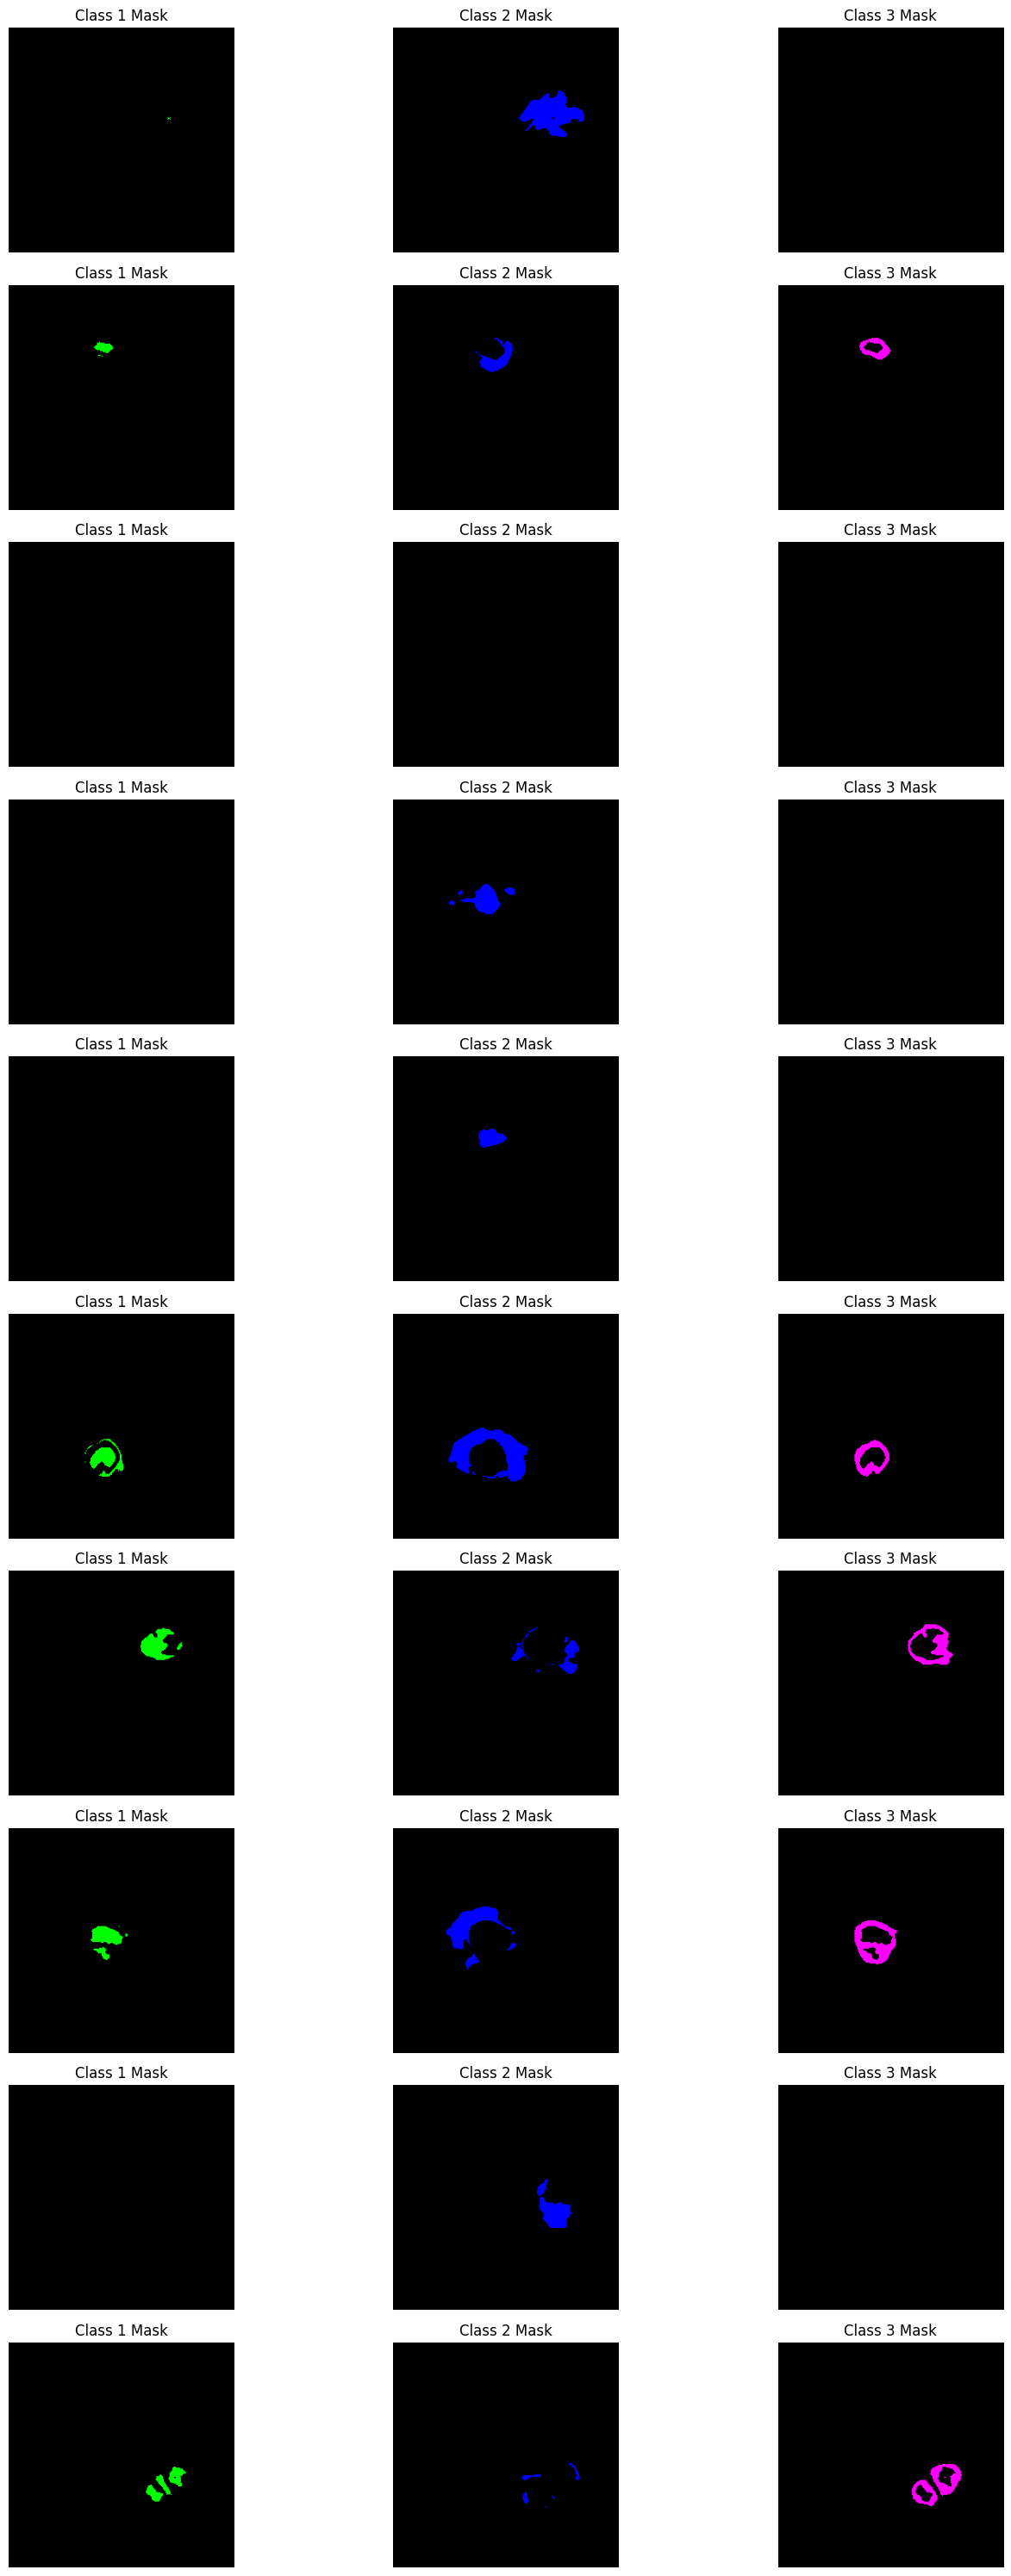

In [ ]:
# Take the 10 images coming from above

test_iter = iter(test_loader)
num_images = 10
fig, axes = plt.subplots(num_images, 3, figsize=(15, num_images * 3))

for i in range(num_images):
    test_image = next(test_iter).to(device)  # (1, 4, H, W, D)

    # Prediction with model
    with torch.no_grad():
        output = model(test_image)  # (1, 2, H, W, D)
        prediction = torch.argmax(output, dim=1).cpu().numpy()  # (1, H, W, D)

    # Select middle slice (e.g. D/2)
    test_image_np = test_image.cpu().numpy()
    slice_idx = test_image_np.shape[4] // 2  # Depth axis D
    pred_mask = prediction[0, :, :, slice_idx]  # Segmentation mask

    # Create individual tumor class masks
    mask_0 = (pred_mask == 0).astype(np.uint8)  # Background
    mask_1 = (pred_mask == 1).astype(np.uint8)  # Class 1
    mask_2 = (pred_mask == 2).astype(np.uint8)  # Class 2
    mask_3 = (pred_mask == 3).astype(np.uint8)  # Class 3

    # Color masks for visualization
    mask_0_colored = np.zeros((*mask_0.shape, 3), dtype=np.uint8)
    mask_1_colored = np.zeros((*mask_1.shape, 3), dtype=np.uint8)
    mask_2_colored = np.zeros((*mask_2.shape, 3), dtype=np.uint8)
    mask_3_colored = np.zeros((*mask_3.shape, 3), dtype=np.uint8)

    # Definisci i colori per ogni classe
    colors = {
        0: [0, 0, 0],        # Background
        1: [0, 255, 0],      # Class 1 (e.g. Non-Enhancing Tumor) (Green)
        2: [0, 0, 255],      # Class 2 (e.g. Edema) (Blue)
        3: [255, 0, 255]     # Class 3 (e.g. Enhancing Tumor) (Purple)
    }

    # Color the masks based on class labels
    mask_1_colored[mask_1 == 1] = colors[1]
    mask_2_colored[mask_2 == 1] = colors[2]
    mask_3_colored[mask_3 == 1] = colors[3]

    # Plot each mask
    axes[i, 0].imshow(mask_1_colored)
    axes[i, 0].set_title("Class 1 Mask")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(mask_2_colored)
    axes[i, 1].set_title("Class 2 Mask")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(mask_3_colored)
    axes[i, 2].set_title("Class 3 Mask")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()